# Pima Indians Diabetes Classification
`sklearn` 결정 트리를 하이퍼파라미터 튜닝
## 데이터 셋 출처
- [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
### 사용 라이브러리

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Data Load

In [2]:
df_pima = pd.read_csv("http://bit.ly/data-diabetes-csv")
df_pima.shape

(768, 9)

### 전처리

In [4]:
in_desc = df_pima.groupby("Outcome")["Insulin"].describe()

In [6]:
df_pima.loc[(df_pima["Insulin"].isnull()) & (df_pima["Outcome"]==1), "Insulin"] = in_desc.loc[1, "50%"]
df_pima.loc[(df_pima["Insulin"].isnull()) & (df_pima["Outcome"]==0), "Insulin"] = in_desc.loc[0, "50%"]

### 학습

In [7]:
target = "Outcome"
features = df_pima.columns.tolist()
features.remove(target)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_pima[features], df_pima[target], test_size=0.2, shuffle=True, random_state=42)

In [10]:
y_train.value_counts(normalize=True)*100

0    65.309446
1    34.690554
Name: Outcome, dtype: float64

In [11]:
y_test.value_counts(normalize=True)*100

0    64.285714
1    35.714286
Name: Outcome, dtype: float64

데이터를 나눌 때, `stratify` 옵션을 타겟값으로주면 데이터가 균일하게 나눠지지만, 해당 옵션을 사용하지 않았는데도 균일하게 나눠진것을 확인

### 모델
분류 모델을 이용해 하이퍼파라미터 튜닝을 진행함

### 하이퍼파라미터 튜닝
하이퍼파라미터는 모델 생성시 사용자가 직접 설정하는 값으로, 어떻게 설정하냐에 따라 모델의 성능에 영향을 줌


#### 수동 튜닝
하이퍼파라미터를 직접 여러개를 생성해 최적의 값을 찾아보는 **그리디 서치**의 일종

In [13]:
# 트리의 깊이
max_depth_list = [5, 7, 9, 12, 15, 20, 40]
# max_featres 비율
max_features_list = [0.5, 0.7, 0.8, 0.9, 1]

In [15]:
accuracy_list = []
for max_depth in max_depth_list:
    for max_features in max_features_list:
        acc_list = []
        model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
        y_predict = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1)
        acc = (y_train==y_predict).mean()
        
        acc_list.append(max_depth)
        acc_list.append(max_features)
        acc_list.append(acc)
        
        accuracy_list.append(acc_list)       

In [16]:
df_acc = pd.DataFrame(accuracy_list, columns=["max_depth", "max_features", "acc"])
df_acc.sort_values(by="acc", ascending=False)[:3]

,max_depth,max_features,acc
3,5,0.9,0.749186
1,5,0.7,0.739414
0,5,0.5,0.734528


In [17]:
# 이 같은 방식으로도 확인 가능
df_acc.nlargest(3, "acc")

,max_depth,max_features,acc
3,5,0.9,0.749186
1,5,0.7,0.739414
0,5,0.5,0.734528


수동으로 지정해준 하이퍼파라미터 값 중에서,  
`max_depth=5`, `max_features=0.9`인 경우에 정확도가 0.74로 가장 높음

#### 랜덤 튜닝
수동 튜닝의 일종임  
범위만 알려주고, 범위 내에서 랜덤하게 뽑아 최적의 하이퍼파라미터를 찾아내는 방식  
하나의 범위를 먼저 넓게 줘서 범위를 줄이고, 여러개의 하이퍼파라미터들이 각각에 대해서 최적의 성능을 내는 범위를 줄여나가는 방식으로 사용하는 편임

In [23]:
accuracy_list = []
for max_depth in np.random.randint(1, 20, 10):
    for max_features in np.random.uniform(0, 1, 10):
        acc_list = []
        model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
        y_predict = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1)
        acc = (y_train == y_predict).mean()
        acc_list.append(max_depth)
        acc_list.append(max_features)
        acc_list.append(acc)
        accuracy_list.append(acc_list)

In [24]:
df_acc = pd.DataFrame(accuracy_list, columns=["max_depth", "max_features", "acc"])
df_acc.nlargest(3, "acc")

,max_depth,max_features,acc
75,3,0.936477,0.737785
76,3,0.942779,0.737785
83,10,0.541980,0.736156


`max_depth=3`, `max_features=0.93 or 0.94`일 경우에 정확도가 0.73으로 가장 높게 나왔음

#### 그리디 서치 (Greed Search)
지정한 범위 내에서 모든 경우의 수를 이용해 최적의 하이퍼파라미터 튜닝값을 찾음

In [26]:
parameters = {"max_depth": np.unique(np.random.randint(1, 20, 10)), "max_features": np.unique(np.random.uniform(0, 1, 10))}

clf = GridSearchCV(estimator=model, param_grid=parameters, scoring="accuracy", n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=19,
                                              max_features=0.4339235716873059,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4, 12, 14, 15, 16, 17, 18]),
                         'max_features': array([0.0271664 , 0.12844761, 0.23000427, 0.33713696, 0.41513106,
       0.52481312, 0.66475745, 0.69669566, 0.83153289, 0.92114542])},
             scoring='accuracy')

In [30]:
pd.DataFrame(clf.cv_results_).shape

(80, 13)

지정된 값 (`max_depth`= [2, 4, 12, 14, 15, 16, 17 , 18] / `max_features`= [0.0271664 , 0.12844761, 0.23000427, 0.33713696, 0.41513106, 0.52481312, 0.66475745, 0.69669566, 0.83153289, 0.92114542])  
각각 8개, 10개의 하이퍼파라미터를 이용해 10*10인 총 100개의 경우의 수를 모두 탐색함  
(중복을 방지하기 위해 `unique`를 사용했기에, `max_depth`의 경우 10개를 랜덤하게 뽑았지만 중복을 제외하고 8개만 남았음)

In [27]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=4, max_features=0.9211454197229048,
                       random_state=42)

In [28]:
clf.best_score_

0.7508130081300813

In [29]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score")[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,0.002500,1.946680e-07,0.001334,0.000236,4,0.921145,"{'max_depth': 4, 'max_features': 0.92114541972...",0.770732,0.731707,0.750000,0.750813,0.015942,1
15,0.002167,2.355166e-04,0.001334,0.000236,4,0.524813,"{'max_depth': 4, 'max_features': 0.52481312133...",0.746341,0.751220,0.705882,0.734481,0.020320,2
18,0.002500,2.973602e-07,0.001167,0.000236,4,0.831533,"{'max_depth': 4, 'max_features': 0.83153288730...",0.741463,0.741463,0.715686,0.732871,0.012151,3


`max_depth=4`, `max_feautres=0.92`일 일 때, 정확도가 0.75로 가장 높았음

#### 랜덤 서치 (Random Search)
그리드 서치와 유사하지만, 각 반복에 대해서 임의값을 선택함

In [32]:
param_distribution = {"max_depth": np.unique(np.random.randint(1, 20, 10)) ,"max_features": np.unique(np.random.uniform(0.1, 1, 10))}
clf = RandomizedSearchCV(estimator=model, param_distributions=param_distribution, n_iter=5, cv=3, n_jobs=-1)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(max_depth=19,
                                                    max_features=0.4339235716873059,
                                                    random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  4,  5,  6,  7, 10, 12, 14, 19]),
                                        'max_features': array([0.1450985 , 0.14936645, 0.23390445, 0.41955525, 0.4570386 ,
       0.47312145, 0.55700947, 0.70646191, 0.77430557, 0.97285588])})

In [33]:
pd.DataFrame(clf.cv_results_).shape

(5, 13)

In [34]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features=0.2339044534271434,
                       random_state=42)

In [35]:
clf.best_score_

0.716594930655189

In [36]:
pd.DataFrame(clf.cv_results_).nsmallest(3, "rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.003501,2.973602e-07,0.001667,0.000236,0.233904,5,"{'max_features': 0.2339044534271434, 'max_dept...",0.731707,0.712195,0.705882,0.716595,0.010992,1
1,0.003834,2.354605e-04,0.001834,0.000472,0.706462,7,"{'max_features': 0.7064619073099252, 'max_dept...",0.712195,0.707317,0.720588,0.713367,0.005481,2
0,0.003001,2.973602e-07,0.001500,0.000000,0.145098,6,"{'max_features': 0.14509849507007172, 'max_dep...",0.673171,0.702439,0.710784,0.695465,0.016128,3


`max_depth=5`, `max_features=0.23`에서 정확도가 0.71로 가장 성능이 좋았음

### Best Estimator

수동 튜닝, 그리디 서치, 랜덤 서치를 통해 하이퍼파라미터를 구했을 때,  
그리디 서치로 찾은 `max_depth=4`, `max_features=0.92`인 경우가 0.75 정확도로 가장 성능이 좋았음  
하이퍼파라미터 튜닝을 진행 할 때, 자신의 상황에 맞는 방식을 선택해 하이퍼파라미터 튜닝을 진행하면됨

#### 그리디 서치나 랜덤 서치를 이용한 하이퍼파라미터 값 이용하기
해당 파일에서는, 가장 최근에 실행한 방식이 랜덤 서치이므로 랜덤 서치에서 얻은 최적의 하이퍼파라미터 값을 사용하게 됨 

In [37]:
best_model = clf.best_estimator_
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features=0.2339044534271434,
                       random_state=42)

In [38]:
y_predict = best_model.predict(X_test)
y_predict[:3]

array([0, 0, 0], dtype=int64)

### 모델 평가

In [39]:
best_model.feature_importances_

array([0.20272591, 0.45584979, 0.01333214, 0.03941655, 0.07380387,
       0.10928427, 0.05981015, 0.04577731])

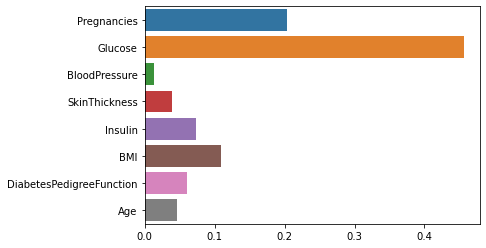

In [40]:
_ = sns.barplot(x=best_model.feature_importances_, y=features)